# Using Restricted Boltzmann Machines as the model of an estimation of distribution algorithm

### Dependencies

In [1]:
from deap import base, creator, tools
from sklearn.neural_network import BernoulliRBM
from sklearn.datasets import fetch_openml
import matplotlib.pyplot as plt
import random, math, time
import numpy as np
import tensorflow as tf


!pip install tqdm &> /dev/null
from tqdm.notebook import trange, tqdm

/opt/venv/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:526: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/opt/venv/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:527: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/opt/venv/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:528: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/opt/venv/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:529: FutureWarning: Passing (type, 1) or '1ty

## Proof of concepts

## Benchmark Problems

### OneMax Problem

The OneMax Problem (or BitCounting) is a simple problem consisting in maximizing the number of ones of a bitstring.

Formally, this problem can be described as finding a string $\vec{x}=\{x_1,x_2,\ldots,x_N\}$, with $x_i\in\{0,1\}$, 
that maximizes the following equation:

$F(\vec{x})=\sum\limits_{i=1}^{N}{x_i}$

In order to define an instance of this problem only is needed to define the length of the bitstring ($N$). For a given $N$,
 the optimum solution of the problem is a string with $N$ ones, i.e., all bits of the string are set to one.

In [2]:
def onemax(individual):
    return np.sum(individual)

def onemin(individual):
    return np.sum(-individual)

### Concatenated Deceptive Traps

$TF(x_1,\ldots,x_l)=\sum\limits_{j=0}^{\frac{l}{k}-1}{B(x_{j \cdot k+1},\ldots,x_{j \cdot k+k})}$

$B(x_1,\ldots,x_k)=\begin{cases}k & \text{if } \sum{x_i}=k \\k-d-\frac{k-d}{k-1}\sum{x_i} & \text{if } \sum{x_i} \lt k\end{cases}$

Deceptive functions are functions
where the lower-order schema fitness averages that contain the local optimum 
have a higher value than the lower-order schema fitness averages that contain the
global optimum in each subfunction.

**For example**: $k=4$ $\wedge$ $d=1$ $\wedge$ $l=100 \implies (x_1,x_2,\ldots,x_{100})$

<table style="border: 1px double black; margin: 10px 0 10px 0">
    <tbody>
        <tr>
            <td style="font-weight: bold; border-widht: 1px; border-right-style: double; padding: 0 10px 0 10px;">Number of Ones</td>
            <td style="border: 1px solid black; padding: 0 10px 0 10px;">4</td>
            <td style="border: 1px solid black; padding: 0 10px 0 10px;">3</td>
            <td style="border: 1px solid black; padding: 0 10px 0 10px;">2</td>
            <td style="border: 1px solid black; padding: 0 10px 0 10px;">1</td>
            <td style="border: 1px solid black; padding: 0 10px 0 10px;">0</td>
        </tr>
        <tr>
            <td style="font-weight: bold; border-widht: 1px; border-right-style: double; padding: 0 10px 0 10px;">Fitness Value</td>
            <td style="border: 1px solid black; padding: 0 10px 0 10px;">4</td>
            <td style="border: 1px solid black; padding: 0 10px 0 10px;">0</td>
            <td style="border: 1px solid black; padding: 0 10px 0 10px;">1</td>
            <td style="border: 1px solid black; padding: 0 10px 0 10px;">2</td>
            <td style="border: 1px solid black; padding: 0 10px 0 10px;">3</td>
        </tr>
    <tbody>
</table>

Trap functions consist of $25$ concatenated subfunctions of length $k = 4$, each
having an optimum at $1111$ and at $0000$. The overall function has therefore $2^{25} - 1$
local optima and $1$ global optimum when the string is full of ones.

$\begin{cases} F(111*)=\frac{4+0}{2}=2 \\F(000*)=\frac{3+2}{2}=2.5 \end{cases}$

$\begin{cases} F(11**)=\frac{4+0+1}{4}=1.25 \\F(00**)=\frac{3+2+2+1}{4}=2.5 \end{cases}$

$\begin{cases} F(1***)=\frac{4+0+3 \cdot 1+2}{8}=1.125 \\F(0***)=\frac{3+3 \cdot 2+3 \cdot 1+0}{8}=1.5 \end{cases}$

In [97]:
def concatenated_deceptive_traps(individual): # k = 4, d = 1
    k = 4
    d = 1
    result = 0

    steps = int(individual.shape[0]/k)
    for i in range(steps):
        sub_sum = np.sum(individual[i*k:(i + 1)*k])
        if sub_sum == k:
            result += k
        elif sub_sum < k:
            result += k - d - ((k-d)/(k-1))*sub_sum

    return result

In [ ]:
test = [1,1,1,1] + [0]*96 # [1,1,1,1,0,0,...,0]
assert 4 + 3 * 24 == concatenated_deceptive_traps(np.array(test))
test[3] = 0 # [1,1,1,0,0,0,...,0]
assert 3 * 24 == concatenated_deceptive_traps(np.array(test))
test[2] = 0 # [1,1,0,0,0,0,...,0]
assert 1 + 3 * 24 == concatenated_deceptive_traps(np.array(test))
test[1] = 0 # [1,0,0,0,0,0,...,0]
assert 2 + 3 * 24 == concatenated_deceptive_traps(np.array(test))
test[0] = 0 # [0,0,0,0,0,0,...,0]
assert 3 + 3 * 24 == concatenated_deceptive_traps(np.array(test))

## RBM for Sampling

By learning the probability distribution of a given input data, it is possible for a Restricted Boltzman Machine to sample new instances from the learnt distribution. One example would be, using MNIST as input data, creating new digits samples that follow the same distribution as MNIST does.

In [ ]:
mnist, targets = fetch_openml('mnist_784', version=1, return_X_y=True)
mnist = mnist / 255

**Warning, RBM training for MNIST can take ~8 minutes.**

In [ ]:
rbm_100 = BernoulliRBM(n_components=100) # Bernoulli Bernoulli RBM with 100 hidden units
rbm_100.fit(mnist)

BernoulliRBM(n_components=100)

In [ ]:
b_h_100 = rbm_100.intercept_hidden_ # Bias from the hidden layer
b_v_100 = rbm_100.intercept_visible_ # Bias from the visible layer
w_100 = rbm_100.components_ # Weights
print(b_h_100.shape)
print(b_v_100.shape)
print(w_100.shape)

(100,)
(784,)
(100, 784)


A graphical way of visualizing what a RBM is learning from the input data (even more when it is an image based input data) is to output the weights for each hidden unit and all its conections with the visible units

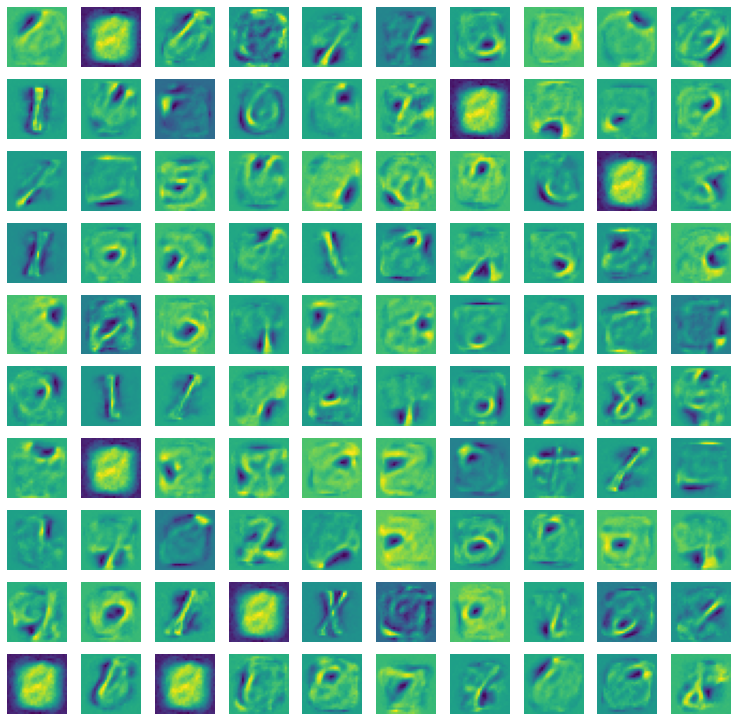

In [ ]:
plt.figure(figsize=(13,13))
for i in range(w_100.shape[0]):
    plt.subplot(10,10,i+1)
    plt.axis('off')
    plt.imshow(np.reshape(w_100[i],(28,28)))
plt.show()

A method for sampling new instances from the probability distribution of the input data is **gibbs sampling**.

In [ ]:
def gibbs_sampling(n,rbm,gibbs_steps=30000,print_steps=False):
    with tf.Session():
        generated = tf.nn.sigmoid(tf.matmul(np.random.random(size=(n,rbm.intercept_hidden_.shape[0])), rbm.components_) + rbm.intercept_visible_).eval() # Initial random input

        if print_steps:
            plt.figure(figsize=(3,3))
            plt.suptitle("Generated random input data")
            cols = 4
            rows = math.ceil(generated.shape[0] / 4)

            if generated.shape[1] % 2 == 0:
                im_shape_w = int(math.sqrt(generated.shape[1]))
                im_shape_h = int(math.sqrt(generated.shape[1]))

            for i in range(generated.shape[0]):
                plt.subplot(rows,cols,i + 1)
                plt.axis('off')
                plt.imshow(generated[i].reshape((im_shape_w,im_shape_h)))

            plt.show()  

        for i in range(gibbs_steps): # Repeat gibbs sampling k times
            generated = rbm.gibbs(generated)
            
            if print_steps and i % 5000 == 0:
                plt.figure(figsize=(3,3))
                plt.suptitle(f"K={i}")
                cols = 4
                rows = math.ceil(generated.shape[0] / 4)

                if generated.shape[1] % 2 == 0:
                    im_shape_w = int(math.sqrt(generated.shape[1]))
                    im_shape_h = int(math.sqrt(generated.shape[1]))

                for i in range(generated.shape[0]):
                    plt.subplot(rows,cols,i + 1)
                    plt.imshow(generated[i].reshape((im_shape_w,im_shape_h)))
                    plt.axis('off')
                plt.show()

        return generated.astype(np.float64)

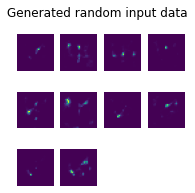

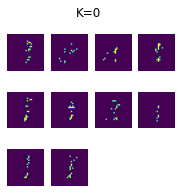

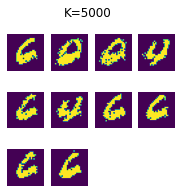

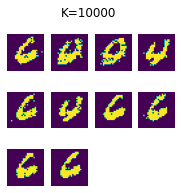

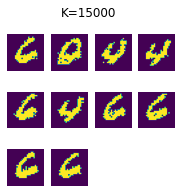

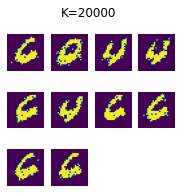

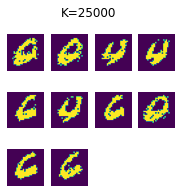

In [ ]:
new_samples = gibbs_sampling(10,rbm_100,print_steps=True) # 10 new instances generated by gibbs sampling

In [ ]:
rbm_log = BernoulliRBM(n_components=math.ceil(math.log2(mnist.shape[1]))) # Bernoulli Bernoulli RBM with log2(784) hidden units
rbm_log.fit(mnist)

BernoulliRBM(n_components=10)

In [ ]:
b_h_log = rbm_log.intercept_hidden_
b_v_log = rbm_log.intercept_visible_
w_log = rbm_log.components_

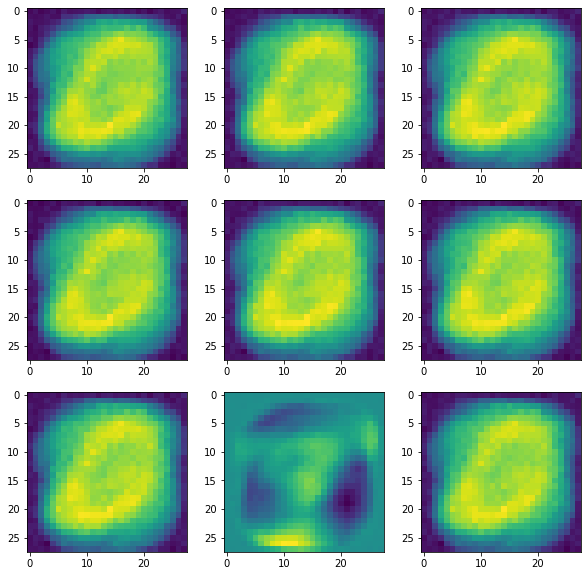

In [ ]:
plt.figure(figsize=(10,10))
for i in range(w_log.shape[0]):
    plt.subplot(3,3,i+1)
    plt.imshow(np.reshape(w_log[i],(28,28)))
plt.show()

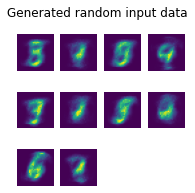

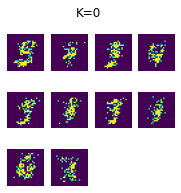

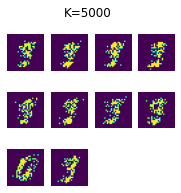

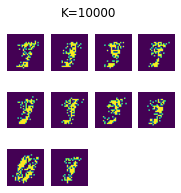

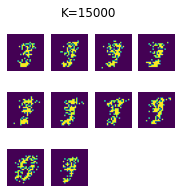

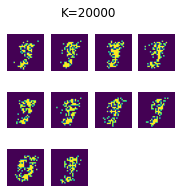

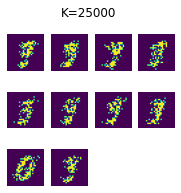

In [ ]:
new_samples = gibbs_sampling(10,rbm_log,print_steps=True) # 10 new instances generated by gibbs sampling

## EDA with RBM

In [ ]:
[3.0,8.0,2.0,5.0][::-1 if False else 1]

[3.0, 8.0, 2.0, 5.0]

In [182]:
class BinaryREDA:
    """
    Estimation of distribution algorithm with RBM distribution modeling

    Parameters
    ----------
    ndim : int
        Dimentionality of each individual
    ngen : int, optional
        Number of generations (default 10)
    nind : int, optional
        Number of individuals each generation (default 100)
    n_h : int, optional
        Number of hidden units in the RBM hidden layer (default math.log2(ndim))

    Attributes
    ----------
    best_ind : array
        Best individual of each generation
    min_fitness : array
        Minimum fitness of each generation
    max_fitness : array
        Maximum fitness of each generation
    mean_fitness : array
        Mean fitness of each generation
    std_fitness : array
        Standard deviation of each generation fitnesses
    """

    def __init__(self, ndim, ngen = 10, nind = 100, n_h = None):
        """
        Parameters
        ----------
        ndim : int
            Dimentionality of each individual
        ngen : int, optional
            Number of generations (default 10)
        nind : int, optional
            Number of individuals each generation (default 100)
        n_h : int, optional
            Number of hidden units in the RBM hidden layer (default math.log2(ndim))
        """

        self.ndim = ndim
        self.ngen = ngen
        self.nind = nind
        self.n_h = n_h if n_h else int(math.log2(self.ndim))
    
    @staticmethod
    def sel_random(population, k):
        return np.random.choice(len(population), size=k, replace=False)

    @staticmethod
    def sel_best(population, fitness, k, maximize, **kwargs):
        return population[np.argsort(fitness)[::-1 if maximize else 1][:k]]

    @staticmethod
    def sel_tournament(population, fitness, k, maximize, tournsize):
        chosen = []
        for i in range(k):
            aspirants = BinaryREDA.sel_random(population, tournsize)
            if maximize:
                chosen.append(population[np.argmax(fitness[aspirants], axis=0)])
            else:
                chosen.append(population[np.argmin(fitness[aspirants], axis=0)])
        return chosen

    @staticmethod
    def sel_roulette(population, fitness, k, maximize,**kwargs):
        s_inds = sorted(list(zip(fitness, population)), reverse=maximize, key=lambda x: x[0])
        sum_fits = sum(fitness)
        chosen = []
        for i in range(k):
            u = random.random() * sum_fits
            partial_sum = 0
            for fit, ind in s_inds:
                partial_sum += fit
                if partial_sum > u:
                    chosen.append(ind)
                    break

        return chosen

    def plot_stats(self):
        fig, ax = plt.subplots(figsize=(10, 5))
        ax.plot(self.max_fitness)
        ax.plot(self.min_fitness)
        ax.errorbar(range(len(self.std_fitness)),self.mean_fitness,yerr=self.std_fitness,fmt="b-o")
        ax.legend(["Max","Min","Mean - Std"], loc="best")
        plt.title("Fitness each generation")
        plt.xlabel("Generation")
        plt.ylabel("Fitness")
        fig.show()

    def eda(self, evaluation_function, selection_function, initial_population = None, selection_amount = 0.3, rand_min = 0., rand_max = 1., stopping_criterion_function = None, maximize=True,**kwargs):
        """
        Parameters
        ----------
        evaluation_function: callable
            Funtion to use to evaluate the individuals.
        selection_function: callable, optional
            Function to use to select the best individuals (default tools.selTournament)
        initial_population : ndarray
            Initial population (default None)
        selection_amount: float, optional
            Percentage of the population that will be used to train RBM (default 0.3)
        rand_min : float, optional
            Minimum value for first generated population (default 0.)
        rand_max : float, optional
            Maximum value for first generated population (default 0.)
        stopping_criterion_function: callable, optional
            Function to use to evaluate if some stopping criterion is reached. This function must have two arguments 'individual' and 'fitness' and return a boolean value (default None)
        maximize: boolean, optional
            Choose either maximizing or minimizing 
        """
        
        if 'tournsize' in kwargs.keys():
            tournsize = kwargs['tournsize']
        else:
            tournsize = 2
        
        if not callable(evaluation_function):
            raise TypeError("The given Evaluation function is not callable")

        if not callable(selection_function):
            raise TypeError("The given Selection function is not callable")            

        if stopping_criterion_function and not callable(stopping_criterion_function):
            raise TypeError("The given Stopping criterion function is not callable")

        # stats of each generation
        self.best_ind = [] 
        self.min_fitness = []
        self.max_fitness = []
        self.mean_fitness = []
        self.std_fitness = []

        # gen 0
        if initial_population is not None and initial_population.shape[0] == self.nind and initial_population.shape[1] == self.ndim:
            population = initial_population
        else:
            population = population if initial_population else np.random.randint(0,high=2,size=(self.nind,self.ndim))      
            np.random.shuffle(population)  
        current_best = None

        for g in trange(self.ngen,position=0, leave=True):
            tqdm.write(f"\n----------Gen {g+1}----------")

            # evaluating
            fitness = np.array(list(map(evaluation_function,population)))

            #selecting
            selected = selection_function(population=population, fitness=fitness, k=int(self.nind* selection_amount), maximize=maximize, tournsize=tournsize)
            current_best = BinaryREDA.sel_best(population,fitness,1, maximize=maximize).reshape(-1)

            # calculating some gen stats
            self.best_ind.append(current_best)
            self.min_fitness.append(min(fitness))
            self.max_fitness.append(max(fitness))
            self.mean_fitness.append(np.mean(fitness))
            self.std_fitness.append(np.std(fitness))

            tqdm.write(f"\tMin population fitness:\t{self.min_fitness[-1]}")
            tqdm.write(f"\tMax population fitness:\t{self.max_fitness[-1]}")
            tqdm.write(f"\tMean population fitness:\t{self.mean_fitness[-1]}")
            tqdm.write(f"\tStd population fitness:\t{self.std_fitness[-1]}")
            tqdm.write(f"\tBest population individual:\t{current_best}")            

            #checking stopping criterion
            if stopping_criterion_function and stopping_criterion_function(current_best,evaluation_function(current_best)):
                break

            #generate RBM distribution model
            t = time.time()
            rbm = BernoulliRBM(n_components=self.n_h, learning_rate=0.001, n_iter=50)
            rbm.fit(selected)
            t = time.time() - t
            tqdm.write(f"\tBBRBM training elapsed time: {t} seconds")

            #sampling next-gen population with a BBRBM
            t = time.time()
            with tf.Session() as session:
                generated = tf.nn.sigmoid(tf.matmul(np.random.random(size=(self.nind,self.n_h)), rbm.components_) + rbm.intercept_visible_).eval()
                prob = np.random.rand(self.nind,self.ndim)
                generated[prob >= generated] = 0
                generated[prob < generated] = 1

                for i in range(100):
                    generated = rbm.gibbs(generated)
                population = generated.astype(np.float64)
            
            t= time.time() - t
            tqdm.write(f"\tSampling elapsed time: {t} seconds")

        return self.max_fitness[-1] if maximize else self.min_fitness[-1],current_best

Some stopping criteria

In [ ]:
def onemax_stopping_criterion(individual,fitness):
    return fitness == len(individual)

def onemin_stopping_criterion(individual,fitness):
    return fitness == 0

## Benchmark

EDA
- Model: RBM
    - 100 visible units
- Individual dimentionality : 100
- Population size: 500 individuals
- Generations : 100


In [187]:
reda = BinaryREDA(100,nind=500, ngen = 100)

In [188]:
reda.eda(onemax, BinaryREDA.sel_tournament, tourn_size=10, selection_amount=0.3, maximize=True)

	Max population fitness:	68.0
	Mean population fitness:	53.566
	Std population fitness:	4.3636732233291715
	Best population individual:	[0. 0. 1. 1. 1. 1. 0. 1. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0. 1.
 0. 0. 0. 1. 1. 1. 0. 0. 1. 1. 1. 1. 0. 1. 1. 0. 1. 1. 1. 1. 1. 0. 0. 1.
 0. 0. 1. 0. 0. 0. 1. 1. 1. 0. 0. 1. 0. 1. 1. 0. 1. 0. 1. 1. 0. 1. 1. 0.
 1. 0. 1. 1. 0. 0. 1. 1. 0. 1. 1. 1. 1. 1. 1. 1. 1. 0. 1. 1. 1. 1. 1. 1.
 1. 1. 0. 1.]
	BBRBM training elapsed time: 0.12628865242004395 seconds
	Sampling elapsed time: 1.3655273914337158 seconds

----------Gen 25----------
	Min population fitness:	40.0
	Max population fitness:	69.0
	Mean population fitness:	53.178
	Std population fitness:	4.261257560861582
	Best population individual:	[0. 0. 1. 0. 1. 1. 1. 1. 0. 1. 1. 0. 1. 1. 1. 1. 0. 1. 1. 1. 1. 1. 0. 1.
 1. 0. 1. 0. 0. 1. 1. 0. 0. 1. 1. 0. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0. 1.
 1. 0. 0. 0. 1. 1. 1. 1. 0. 1. 0. 1. 0. 1. 1. 1. 0. 1. 1. 0. 1. 1. 1. 1.
 1. 0. 1. 1. 1. 0. 1. 1. 0. 1. 0. 1. 

(66.0,
 array([0., 0., 1., 0., 1., 1., 0., 0., 0., 1., 1., 1., 1., 0., 1., 1., 1.,
        0., 1., 0., 1., 1., 1., 1., 0., 0., 0., 1., 1., 0., 0., 0., 1., 0.,
        0., 1., 0., 0., 1., 1., 1., 0., 0., 1., 1., 1., 1., 1., 1., 0., 1.,
        1., 1., 1., 0., 0., 0., 1., 1., 1., 0., 1., 1., 1., 1., 0., 1., 0.,
        0., 1., 1., 1., 1., 1., 0., 1., 1., 1., 1., 1., 1., 1., 0., 1., 1.,
        1., 1., 0., 1., 0., 0., 1., 1., 1., 1., 1., 1., 1., 1., 1.]))

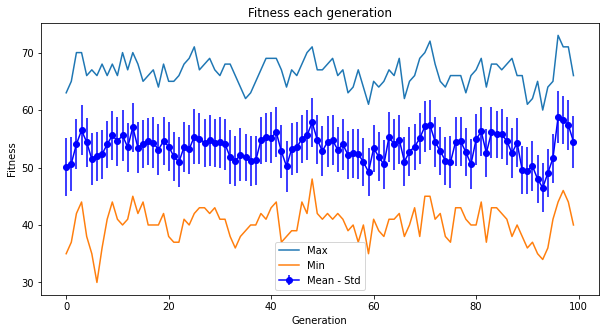

In [189]:
reda.plot_stats()

In [190]:
reda.eda(concatenated_deceptive_traps, BinaryREDA.sel_tournament, tourn_size=10, selection_amount=0.3, maximize=True)

	Max population fitness:	52.0
	Mean population fitness:	31.89
	Std population fitness:	5.848922977779755
	Best population individual:	[0. 1. 1. 0. 0. 0. 1. 0. 1. 0. 0. 0. 1. 1. 1. 1. 0. 0. 1. 1. 1. 0. 0. 0.
 0. 0. 0. 0. 0. 1. 1. 0. 1. 1. 1. 1. 0. 1. 1. 0. 0. 0. 0. 1. 0. 1. 0. 0.
 1. 0. 0. 0. 0. 0. 1. 1. 0. 1. 0. 1. 1. 1. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 0. 1. 1. 1. 0. 0. 0. 1. 1. 1. 1. 0. 1. 0. 1. 0.
 1. 1. 1. 1.]
	BBRBM training elapsed time: 0.09586596488952637 seconds
	Sampling elapsed time: 1.413421392440796 seconds

----------Gen 25----------
	Min population fitness:	15.0
	Max population fitness:	46.0
	Mean population fitness:	31.998
	Std population fitness:	5.590527345429946
	Best population individual:	[0. 1. 1. 0. 1. 1. 1. 1. 0. 0. 1. 1. 0. 0. 1. 0. 0. 0. 0. 0. 0. 1. 1. 0.
 1. 1. 0. 0. 1. 0. 0. 0. 0. 1. 1. 0. 1. 0. 1. 1. 0. 1. 1. 1. 0. 1. 0. 1.
 1. 0. 1. 0. 0. 0. 1. 0. 0. 1. 0. 1. 1. 1. 1. 1. 0. 1. 0. 0. 1. 1. 0. 1.
 1. 1. 1. 1. 1. 0. 1. 1. 0. 0. 1. 0. 1. 

(50.0,
 array([0., 0., 1., 0., 1., 1., 1., 1., 0., 1., 1., 0., 0., 1., 1., 0., 1.,
        0., 1., 0., 0., 1., 1., 0., 1., 1., 1., 1., 1., 0., 1., 0., 1., 1.,
        1., 1., 1., 0., 1., 1., 1., 1., 1., 1., 0., 0., 0., 0., 0., 0., 0.,
        1., 0., 0., 1., 0., 1., 1., 0., 0., 1., 1., 1., 0., 1., 1., 0., 0.,
        1., 1., 1., 1., 0., 0., 1., 0., 1., 1., 0., 0., 1., 1., 1., 1., 0.,
        1., 0., 0., 0., 0., 0., 1., 1., 0., 0., 1., 0., 0., 1., 0.]))

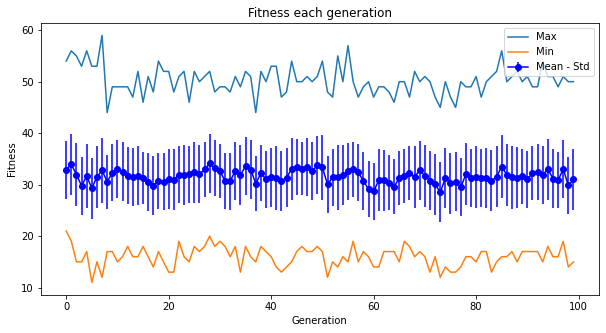

In [191]:
reda.plot_stats()

In [192]:
pop = np.zeros((500,100))
pop[0,0] = 1
pop[1,0] = 1
pop[1,1] = 1
reda.eda(onemax, BinaryREDA.sel_tournament, tourn_size=10, selection_amount=0.1, maximize=True, initial_population=pop)

	Max population fitness:	66.0
	Mean population fitness:	52.69
	Std population fitness:	4.836724097982021
	Best population individual:	[1. 1. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0. 1. 1. 1. 0. 1. 1. 1. 1. 1. 0.
 1. 1. 1. 0. 0. 1. 0. 1. 1. 1. 0. 0. 1. 0. 0. 1. 1. 0. 1. 1. 0. 1. 0. 1.
 0. 1. 1. 0. 0. 0. 1. 0. 1. 1. 1. 0. 0. 0. 1. 0. 1. 1. 0. 1. 1. 1. 1. 0.
 1. 1. 1. 0. 1. 1. 1. 0. 1. 0. 1. 1. 0. 1. 1. 1. 1. 0. 0. 1. 1. 1. 1. 0.
 0. 1. 1. 0.]
	BBRBM training elapsed time: 0.0771324634552002 seconds
	Sampling elapsed time: 1.3951005935668945 seconds

----------Gen 25----------
	Min population fitness:	38.0
	Max population fitness:	70.0
	Mean population fitness:	53.654
	Std population fitness:	4.869320691841932
	Best population individual:	[1. 1. 1. 1. 1. 1. 0. 0. 1. 1. 1. 0. 0. 1. 0. 0. 1. 1. 1. 0. 1. 1. 1. 1.
 0. 0. 1. 0. 1. 1. 1. 1. 1. 1. 0. 1. 1. 1. 0. 1. 0. 0. 1. 1. 1. 1. 1. 1.
 1. 1. 0. 0. 0. 1. 1. 1. 1. 0. 1. 1. 0. 1. 1. 1. 1. 1. 1. 0. 0. 1. 1. 1.
 0. 0. 1. 0. 0. 0. 1. 1. 0. 1. 1. 1. 1. 

(65.0,
 array([1., 1., 0., 1., 1., 1., 1., 1., 1., 0., 0., 0., 1., 1., 0., 1., 1.,
        1., 1., 1., 0., 0., 1., 1., 0., 1., 0., 1., 1., 0., 0., 0., 1., 0.,
        1., 0., 0., 1., 1., 1., 1., 1., 0., 0., 1., 1., 0., 0., 1., 1., 0.,
        1., 1., 1., 1., 0., 1., 0., 0., 1., 1., 1., 1., 1., 1., 1., 0., 1.,
        1., 1., 1., 1., 0., 0., 1., 1., 0., 1., 1., 1., 1., 0., 0., 0., 1.,
        1., 1., 1., 0., 1., 0., 1., 0., 1., 1., 0., 1., 1., 0., 1.]))

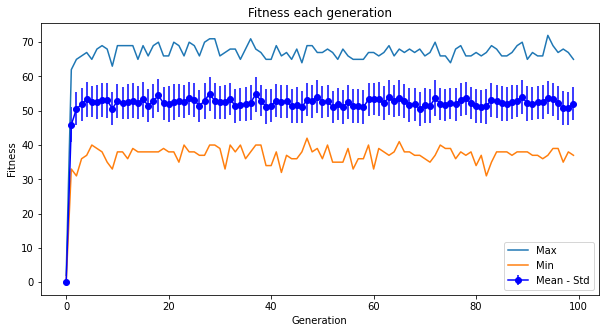

In [193]:
reda.plot_stats()

In [194]:
reda.eda(onemax, BinaryREDA.sel_tournament, tourn_size=10, selection_amount=0.3, maximize=False)

	Max population fitness:	69.0
	Mean population fitness:	55.188
	Std population fitness:	4.098860329408652
	Best population individual:	[1. 1. 0. 0. 0. 1. 1. 0. 0. 1. 0. 0. 0. 1. 0. 0. 0. 1. 1. 1. 0. 1. 0. 0.
 0. 0. 1. 1. 0. 1. 1. 0. 0. 1. 0. 0. 1. 1. 0. 0. 1. 1. 1. 1. 0. 0. 1. 1.
 1. 1. 1. 1. 0. 1. 1. 0. 1. 1. 0. 0. 0. 0. 0. 1. 1. 0. 0. 1. 1. 1. 0. 0.
 1. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 1. 0. 1. 1. 1. 0. 0. 0. 0. 0.
 1. 0. 0. 0.]
	BBRBM training elapsed time: 0.12714529037475586 seconds
	Sampling elapsed time: 1.5212409496307373 seconds

----------Gen 25----------
	Min population fitness:	40.0
	Max population fitness:	70.0
	Mean population fitness:	55.432
	Std population fitness:	4.366391645283322
	Best population individual:	[0. 0. 1. 0. 0. 0. 0. 0. 1. 1. 1. 0. 0. 0. 1. 1. 0. 1. 1. 1. 0. 0. 0. 0.
 0. 1. 1. 0. 1. 0. 1. 0. 0. 1. 1. 0. 0. 0. 0. 0. 1. 0. 0. 1. 0. 0. 1. 1.
 1. 0. 1. 1. 0. 0. 1. 1. 0. 0. 0. 1. 0. 0. 0. 0. 1. 1. 0. 1. 0. 1. 0. 0.
 1. 0. 1. 1. 1. 1. 0. 0. 0. 0. 1. 0. 0

(38.0,
 array([0., 1., 0., 0., 0., 0., 1., 1., 0., 1., 1., 1., 1., 1., 0., 1., 1.,
        1., 0., 0., 1., 0., 1., 0., 0., 0., 1., 0., 0., 1., 0., 1., 0., 0.,
        0., 0., 0., 0., 0., 1., 0., 1., 0., 1., 1., 1., 1., 0., 0., 1., 0.,
        0., 0., 0., 1., 0., 0., 0., 1., 1., 0., 1., 1., 0., 1., 0., 0., 1.,
        0., 0., 0., 1., 0., 1., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.,
        1., 0., 1., 0., 0., 0., 1., 0., 0., 0., 1., 0., 1., 0., 0.]))

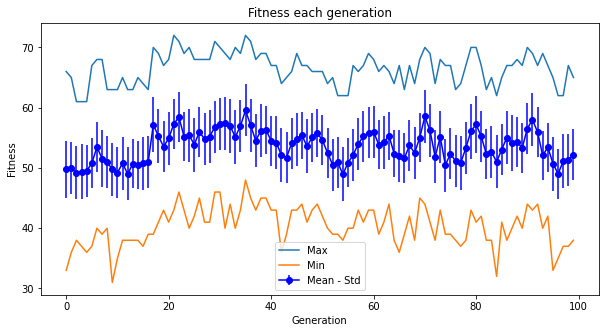

In [195]:
reda.plot_stats()